## Table of Contents

1. [General Settings](#settings)
2. [Initial Exploration](#exploration)
    1. [Variável Target](#target)
    2. [Latitude e Longitude](#latlng)
    3. [Divisões Geográficas](#geo)
    4. [Características Físicas](#fisicas)
    5. [Variáveis Coletadas](#coletadas)
    6. [Multicolinearidade](#multicolin)
3. [Modelagem](#model)
    1. [Métricas](#metricas)
    2. [Pré-processamento](#preprocess)
    3. [Tunning](#tunning)
    4. [SHAP Values](#shap)

## 1. General Settings <a class="anchor" id="settings"></a>

In [115]:
import pandas as pd
import numpy as np
import math
from scipy import stats
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ptitprince as pt
%matplotlib inline 
sns.set_context('notebook')

from IPython.display import display

## 2. Initial Exploration <a class="anchor" id="exploration"></a>

In [147]:
data = pd.read_table('C:/Python/Projetos/Loft/data/Base_Final.txt', sep=";", encoding='utf-8')

In [148]:
cols = ['id', 'address', 'prefix', 'tower_name', 'Bairros Atendidos', 'Zona', 'latitude',
        'longitude', 'building_type', 'rooms', 'garages', 'useful_area',
        'restaurantes', 'distancia_mercado', 'distancia_metro', 'HDI', 'HDI.Income', 'HDI.Life.Expectancy', 'HDI.Education',
        'minimum_estimate', 'maximum_estimate', 'point_estimate',]

data = data[cols]

def convert_string_to_float(string):
    """
    Corrigir o formato dos campos numéricos que possuem caracter ',' ao invés de '.'
    """
    if type(string) == str:
        if len(string.split(",")) > 1:
            return float(string.split(",")[0] + "." + string.split(",")[1])
        else:
            return float(string)
    
    return string
    
cols_to_change = ['distancia_mercado', 'distancia_metro', 'HDI', 'HDI.Income', 'HDI.Life.Expectancy', 'HDI.Education',
                  'latitude', 'longitude']

for col in cols_to_change:
    data[col] = data[col].apply(convert_string_to_float)

In [149]:
display(data.head())
display(data.describe().style)

id                 address  prefix   tower_name  \
0   0        Alameda Itu, 254  1421.0  Torre única   
1   1    Alameda Santos, 1398  1419.0  Torre única   
2   2  Avenida Paulista, 1195  1311.0  Torre única   
3   3  Avenida Paulista, 1195  1311.0  Torre única   
4   4    Alameda Santos, 1126  1419.0  Torre única   

                                   Bairros Atendidos    Zona   latitude  \
0  JARDINS – Cerqueira César / Jardim Paulista / ...  Centro -23.566198   
1  JARDINS – Cerqueira César / Jardim Paulista / ...  Centro -23.563870   
2               CONSOLAÇÃO – Consolação / Bela Vista  Centro -23.564069   
3               CONSOLAÇÃO – Consolação / Bela Vista  Centro -23.564069   
4  JARDINS – Cerqueira César / Jardim Paulista / ...  Centro -23.565340   

   longitude building_type  rooms  ...  restaurantes  distancia_mercado  \
0 -46.656900   Apartamento      3  ...       13817.0           0.200777   
1 -46.655601   Apartamento      2  ...       13832.0           0.356923   
2 -46.653563   Apartamento      3  ...       13917.0           0.348151   
3 -46.653563   Apartamento      4  ...       13917.0           0.348151   
4 -46.653768   Apartamento      3  ...       13888.0           0.335789   

   distancia_metro    HDI  HDI.Income  HDI.Life.Expectancy  HDI.Education  \
0         0.422073  0.889       0.947                0.922          0.805   
1         0.181474  0.889       0.947                0.922          0.805   
2         0.055019  0.889       0.947                0.922          0.805   
3         0.055019  0.889       0.947                0.922          0.805   
4         0.188834  0.889       0.947                0.922          0.805   

   minimum_estimate  maximum_estimate  point_estimate  
0           1794760         2428210.0         2111490  
1            517539          700200.0          608870  
2           1787100         2417840.0         2102470  
3           2344260         3171640.0         2757950  
4            956862         1294580.0         1125720  

[5 rows x 22 columns]

### 2.1. Variável Target <a class="anchor" id="target"></a>

In [150]:
data['point_estimate'].describe()

count    2.900600e+04
mean     1.337443e+06
std      2.165543e+06
min     -1.000000e+00
25%     -1.000000e+00
50%      7.848100e+05
75%      1.648170e+06
max      4.773590e+07
Name: point_estimate, dtype: float64

Citar o fato de que existem valores com -1 (missing)... decidir se vou imputar os dados ou não.

In [151]:
round(100*len(data[data['point_estimate']==-1])/len(data),0)

29.0

In [152]:
data = data[data['point_estimate'] != -1]


 mu = 1560124.65 and sigma = 1240954.65

Skewness: 1.753563
Kurtosis: 3.137989

 mu = 14.07 and sigma = 0.81 (after normalization)

Skewness after normalization: 0.579283
Kurtosis after normalization: 0.305927


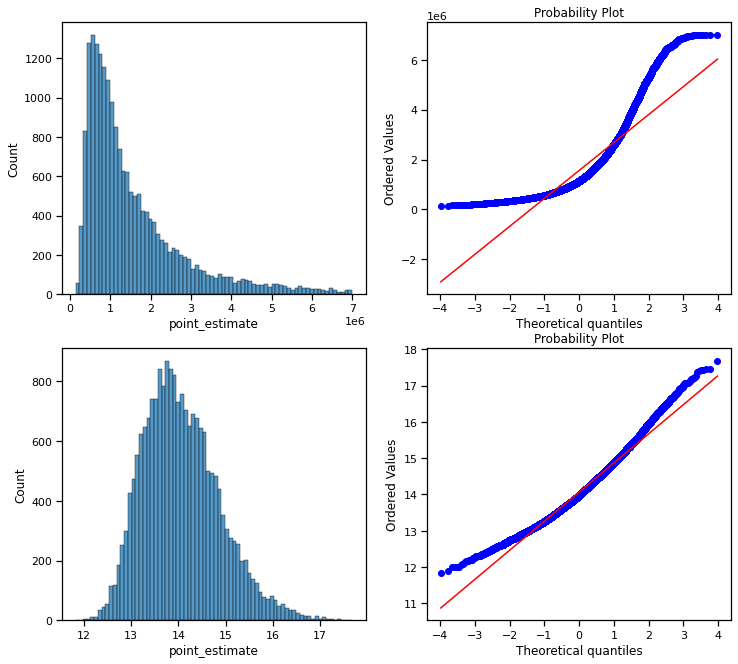

In [153]:
data_to_plot = data[data['point_estimate'] <= 7000000]['point_estimate']
data_normalized = np.log1p(data['point_estimate'])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data_to_plot)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

fig = plt.figure(figsize=(12, 11))

# Plot Histogram
ax1 = plt.subplot(221)
sns.histplot(data_to_plot, ax=ax1)

ax2 = plt.subplot(222)
stats.probplot(data_to_plot, plot=plt)

ax3 = plt.subplot(223)
sns.histplot(data_normalized, ax=ax3)

ax4 = plt.subplot(224)
stats.probplot(data_normalized, plot=plt)

print("Skewness: %f" % data_to_plot.skew())
print("Kurtosis: %f\n" % data_to_plot.kurt())

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data_normalized)
print( ' mu = {:.2f} and sigma = {:.2f} (after normalization)\n'.format(mu, sigma))

print("Skewness after normalization: %f" % data_normalized.skew())
print("Kurtosis after normalization: %f" % data_normalized.kurt())

In [154]:
data['point_estimate'] = np.log1p(data['point_estimate'])

### 2.2. Latitude e Longitude <a class="anchor" id="latlng"></a>

In [155]:
print(max(data['latitude']))
print(min(data['latitude']))

23.539985
-25.6236205


In [156]:
corrige_lat_lng = lambda x: x*(-1) if x > 0 else x
data['latitude'] = data['latitude'].apply(corrige_lat_lng)
data['longitude'] = data['longitude'].apply(corrige_lat_lng)

In [157]:
# Existem casos que vieram com longitude zerada.
# Por mais que poderíamos talvez imputar esses valores, por se tratar de poucas linhas (2) escolhi excluir esses exemplos
data = data[data['longitude'] <= -20]

<AxesSubplot:>

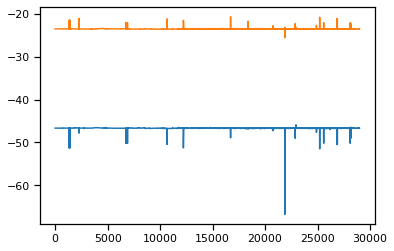

In [158]:
data['longitude'].plot()
data['latitude'].plot()

In [159]:
data = data[((data['latitude'] <= -23.45)&(data['latitude'] >= -23.69))&
            ((data['longitude'] <= -46.50)&(data['longitude'] >= -46.78))]

In [160]:
fig = px.scatter_mapbox(data, lat="latitude", lon="longitude",
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Pelo plot de densidade no mapa abaixo, podemos observar algumas regiões com média de preço maior que outras, assim como já esperávamos. Isso nos leva a crer que utilizar variáveis que delimitam zonas/bairros para a modelagem irá contribuir para discriminar zonas de valor.

In [161]:
fig = px.density_mapbox(data, lat='latitude', lon='longitude', z='point_estimate', radius=10,
                        center=dict(lat=0, lon=180), zoom=0,
                        mapbox_style="stamen-terrain")
fig.show()

### 2.3. Divisões Geográficas <a class="anchor" id="geo"></a>

In [180]:
data.loc[:,'Bairro'] = data['Bairros Atendidos'].copy().map(lambda x: x.split(" – ")[0] if type(x) == str else x)
data.loc[:,'Zona'] = data['Zona'].copy().map(lambda x: 'Zona Leste' if x == 'Zona leste 2' else x)
data = data[~data['Zona'].isna()].copy()

Text(0.5, 1.0, 'Quantidade de Exemplos por Zona')

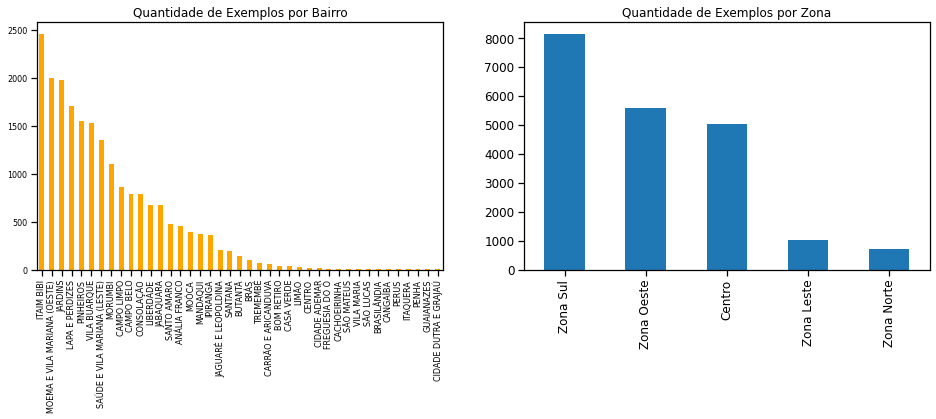

In [193]:
plt.figure(figsize=(16,10))

# Bairros
ax1 = plt.subplot(221)
data['Bairro'].value_counts().plot.bar(ax=ax1, rot=90, fontsize=8, color=['orange'])
plt.title("Quantidade de Exemplos por Bairro")

# Bairros
ax2 = plt.subplot(222)
data['Zona'].value_counts().plot.bar(ax=ax2, rot=90, fontsize=12)
plt.title("Quantidade de Exemplos por Zona")

Analisar a distribuição de preços por bairro e por zona

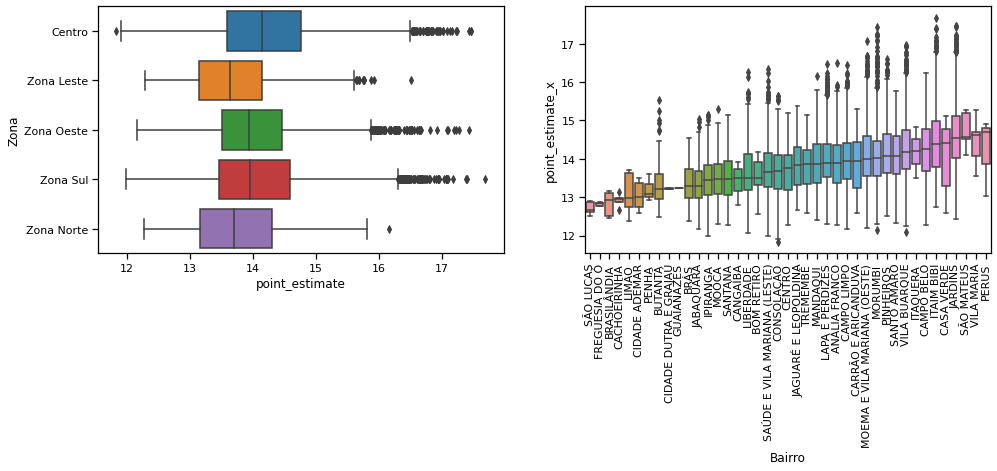

In [220]:
plt.figure(figsize=(16,10))

ax1 = plt.subplot(221)
sns.boxplot(y="Zona", x="point_estimate", data=data, ax=ax1)


temporary_df = data.copy()
temporary_df = temporary_df.merge(temporary_df[['Bairro','point_estimate']].
                   groupby('Bairro').
                   median().
                   sort_values(by='point_estimate'), how='left', on=['Bairro']).sort_values(by='point_estimate_y').copy()
ax2 = plt.subplot(222)
sns.boxplot(x='Bairro', y='point_estimate_x', data=temporary_df)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90);

    1. Zonas como zona Sul e Centro possuem preços mais altos;
    2. Bairros como Jardins, Itaim Bibi, Moema e Vila Mariana possuem preços mais altos do que bairros como Mooca e Liberdade;
    3. Existem bairros que estão subrepresentados em nossa base de dados como Perus, Vila Maria, São Mateus, São Lucas, Freguesia do Ó e Brasilândia;

Bairros com menos do que 100 exemplos serão considerados como um único bairro.

In [329]:
tmp = data[['Bairro','id']].groupby('Bairro').count().reset_index().copy()
bairros_subrepresentados = list(tmp[tmp['id'] <= 100]['Bairro'])
data['Bairro'] = data['Bairro'].map(lambda x: '<100' if x in bairros_subrepresentados else x)

### 2.4. Características Físicas <a class="anchor" id="fisicas"></a>

Características físicas são variáveis relacionadas a tipo de prédio, tipo de apartamento, área, banheiros, garagem, quartos etc. No geral, são as características que logo de cara saltam aos olhos dos compradores. Portanto, uma hipótese inicial é dizer que tais características são melhores preditores ou estão mais bem correlacionadas ao preço de um imóvel.

No nosso dataset, as características físicas são:

- building_type;
- rooms;
- garages;
- useful_area.

In [221]:
data['building_type'].unique()

array(['Apartamento', 'Cobertura'], dtype=object)

id
building_type       
Apartamento    16314
Cobertura       4162

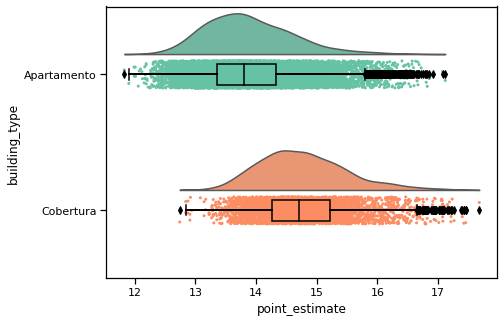

In [258]:
display(data[['building_type','id']].groupby('building_type').count())

#adding color
pal = "Set2"
f, ax = plt.subplots(figsize=(7, 5))

ax = pt.half_violinplot(x = 'point_estimate', 
                        y = 'building_type', 
                        data = data, 
                        palette = pal, bw = .2, cut = 0.,scale = "area", width = .6, inner = None, orient = 'h')

ax = sns.stripplot(x = 'point_estimate', 
                 y = 'building_type', 
                 data = data, 
                 palette = pal,
                 edgecolor = "white",
                 size = 3, jitter = 1, zorder = 0, orient = 'h')

ax = sns.boxplot(x = 'point_estimate', 
               y = 'building_type', 
               data = data, 
               color = "black",
               width = .15, zorder = 10, showcaps = True,
               boxprops = {'facecolor':'none', "zorder":10}, showfliers=True,
               whiskerprops = {'linewidth':2, "zorder":10},
               saturation = 1, orient = 'h')

In [231]:
display(data[['rooms','garages','useful_area']].describe())
qtd_missing_rooms = len(data[data['rooms'] == -1])
qtd_missing_garages = len(data[data['garages'] == -1])

print("Quantidade de casos sem quartos: %d" % (qtd_missing_rooms))
print("Quantidade de casos sem garagem: %d" % (qtd_missing_garages))

rooms       garages   useful_area
count  20476.000000  20476.000000  20476.000000
mean       2.877515      2.067445    165.544540
std        0.935445      1.556268    134.364413
min       -1.000000     -1.000000     22.000000
25%        2.000000      1.000000     78.000000
50%        3.000000      2.000000    123.000000
75%        4.000000      3.000000    208.000000
max        8.000000     16.000000   1975.000000

Quantidade de casos sem quartos: 3
Quantidade de casos sem garagem: 1194


Existem casos na nossa base com quantidade de quartos e garagens igual a -1. São missing values que precisaremos fazer alguma tratativa (imputação, p. ex.). A quantidade de exemplos sem garagem é muito maior do que a quantidade de exemplos sem quartos. Fazendo uma breve pesquisa no google por alguns endereços, parece se tratar de casos em que o prédio não possui a quantidade de vagas suficiente para todos os apartamentos. Segundo matéria divulgada pelo Estadão ao final de 2019, 4 em cada 10 apartamentos novos em São Paulo não possuem garagem. Portanto, não parece uma hipótese muito distante da realidade considerar que esses casos não possuem garagem.

In [238]:
data['garages'] = data['garages'].replace({-1:0})
data['rooms'] = data['rooms'].replace({-1: np.nan})

<AxesSubplot:xlabel='garages', ylabel='point_estimate'>

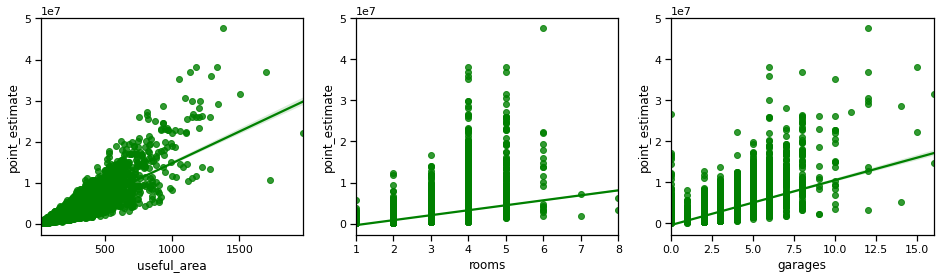

In [277]:
fig, ax = plt.subplots(1, 3, figsize = (16, 4))

sns.regplot(x='useful_area',y=np.expm1(data['point_estimate']), data=data, ax=ax[0], color='green')
sns.regplot(x='rooms',y=np.expm1(data['point_estimate']), data=data, ax=ax[1], color='green')
sns.regplot(x='garages',y=np.expm1(data['point_estimate']), data=data, ax=ax[2], color='green')

### 2.5. Variáveis Coletadas <a class="anchor" id="coletadas"></a>

Para o desenvolvimento deste case, foram coletadas algumas informações extra. Essas informações foram coletadas com base nas coordenadas já presentes na base. Entre elas, temos:

- Distância do metrô mais próximo dos imóveis. Essa informação foi coletada com o intuito de ter uma medida de mobilidade por meio de transportes públicos;
- Quantidade de restaurantes disponíveis pelo Ifood. Essa informação foi coletada através da API do Ifood pelo endpoint https://marketplace.ifood.com.br/v1/merchants. A response trás o total de restaurantes disponíveis dada uma latitude e uma longitude;
- Distância média dos três mercados mais próximos ao imóvel. 
- IDH da região. Considerou-se tanto o IDH geral quanto o IDH calculado com base em renda, expectativa de vida e educação. Essas variáveis são bem correlacionadas, então provavelmente será escolhida apenas uma delas para consideração no modelo.

In [292]:
data[['restaurantes', 
      'distancia_mercado', 
      'distancia_metro', 
      'HDI', 
      'HDI.Income', 
      'HDI.Life.Expectancy', 
      'HDI.Education']].describe()

restaurantes  distancia_mercado  distancia_metro           HDI  \
count  20476.000000       20476.000000     20476.000000  20476.000000   
mean   12030.610715           0.409877         1.197933      0.835192   
std     1980.090313           0.181076         0.863632      0.041495   
min       31.000000           0.046310         0.026213      0.768500   
25%    10740.750000           0.285086         0.541770      0.797111   
50%    12780.000000           0.373448         0.928878      0.859500   
75%    13404.250000           0.497870         1.683650      0.859500   
max    14288.000000           1.315443         6.548529      0.889000   

         HDI.Income  HDI.Life.Expectancy  HDI.Education  
count  20476.000000         20476.000000   20476.000000  
mean       0.868128             0.888752       0.756803  
std        0.060869             0.023587       0.040506  
min        0.752250             0.847250       0.712417  
25%        0.817778             0.868333       0.714556  
50%        0.901500             0.898250       0.786500  
75%        0.901500             0.898250       0.786500  
max        0.947000             0.922000       0.805000

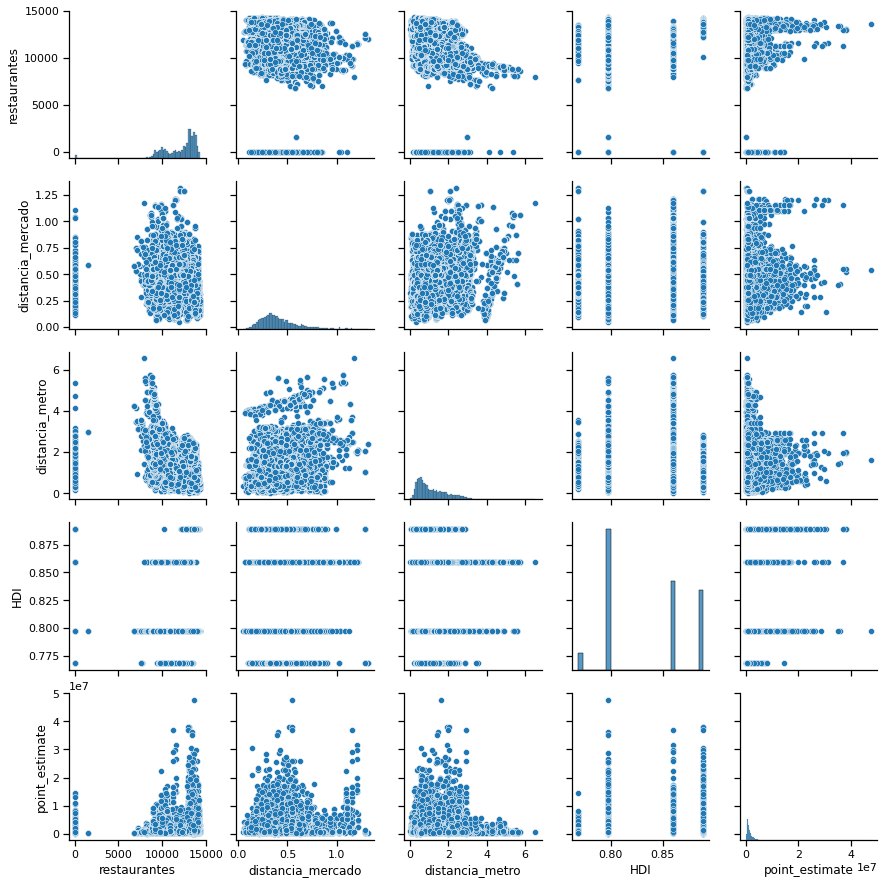

In [305]:
tmp = data[['restaurantes', 'distancia_mercado', 'distancia_metro', 'HDI', 'point_estimate']].copy()
tmp['point_estimate'] = np.expm1(tmp['point_estimate'])

sns.pairplot(tmp)

Verificando o pairplot, não parece haver uma relação muito forte entre as variáveis coletadas e o preço dos imóveis. Visualmente, a quantidade de restaurantes presentes nas proximidades parece ter alguma relação com o nosso target. Porém, essa variável possui alguns exemplos zerados ou com valores abaixo do resto da distribuição. Tornaremos estes valores nulos e faremos a sua tratativa posteriormente.

In [311]:
data['restaurantes'] = data['restaurantes'].apply(lambda x: np.nan if x <= 5000 else x)

<AxesSubplot:xlabel='restaurantes', ylabel='point_estimate'>

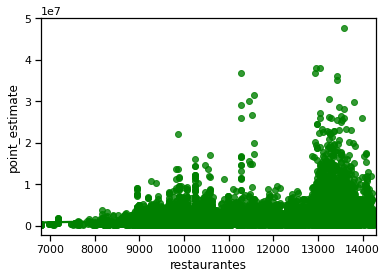

In [312]:
sns.regplot(x='restaurantes',y=np.expm1(data['point_estimate']), data=data, color='green')

### 2.6. Multicolinearidade <a class="anchor" id="multicolin"></a>

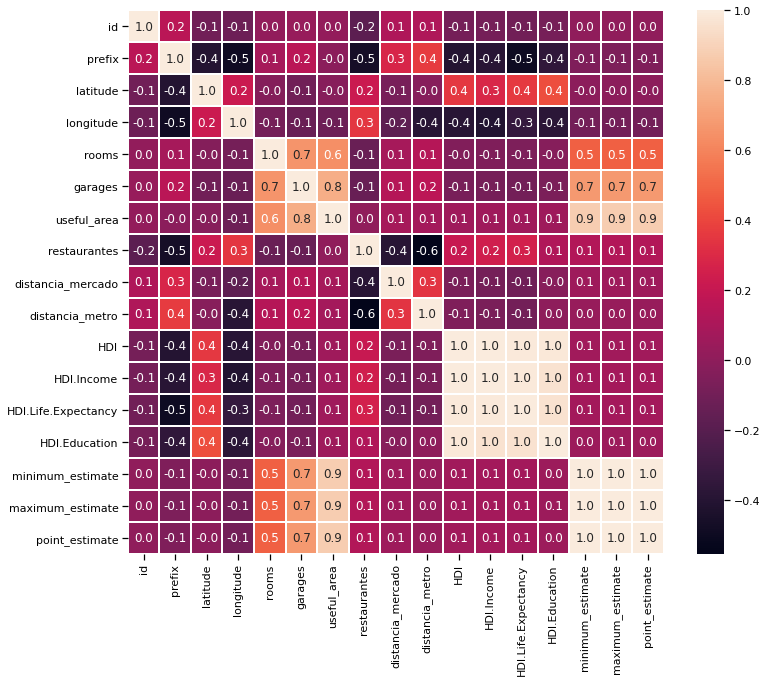

In [332]:
f,ax = plt.subplots(figsize=(12,10))

tmp = data.copy()
tmp['point_estimate'] = np.expm1(tmp['point_estimate'])

sns.heatmap(tmp.corr(), annot = True,linewidths=.4, fmt='.1f', ax=ax)
plt.show()

- Podemos verificar que as características físicas do imóvel (quantidade de quartos, garagem e área útil) são bem correlacionadas com o preço assim como entre si. Isso significa que temos um problema de multicolinearidade. Poderíamos utilizar alguma técnica como o PCA para tratar isto. Porém, tal uso/escolha depende da finalidade da criação do modelo. Utilizando-se de uma técnica como o PCA diminuiríamos a interpretabilidade de nossos resultados, pois relação entre as variáveis preditoras e o valor final seria menos direta.

- Por hora, iremos manter tais variáveis no dataset, a fim de não perdermos informações importantes sobre os imóveis.

- Com relação ao HDI (IDH), consideraremos apenas o HDI geral para a modelagem.

- As variáveis minimum_estimate e maximum_estimate também serão desconsideradas. Em uma situação real, em que tentamos prever preços de imóveis a partir de transações reais, dificilmente teríamos informações sobre preço mínimo e máximo (poderíamos associar ao nosso modelo um outro modelo que tenta prever quantis, que forneceria a estimativa de preço mínimo e máximo aceitável pelo mercado)

In [317]:
data_to_use = data[['Zona','Bairro', 'building_type','rooms','garages','useful_area','restaurantes','distancia_mercado', 
                    'distancia_metro', 'HDI', 'point_estimate']].copy()

## 3. Modelagem <a class="anchor" id="model"></a>

In [335]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize

In [359]:
features = ['Zona','Bairro', 'building_type','rooms','garages','useful_area','restaurantes','distancia_mercado', 
                    'distancia_metro', 'HDI']

features_categ = ['Zona', 'Bairro', 'building_type']
features_num = ['rooms','garages','useful_area','restaurantes','distancia_mercado', 'distancia_metro', 'HDI']

### 3.1. Métricas <a class="anchor" id="metricas"></a>

In [360]:
def rmsle(y_true,y_pred):
    assert len(y_true) == len(y_pred)
    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

def rmse(y_true,y_pred):
    assert len(y_true) == len(y_pred)
    return np.square(y_pred - y_true).mean() ** 0.5

from sklearn.metrics import make_scorer

rmsle_score = make_scorer(rmsle)
rmse_score = make_scorer(rmse)

### 3.2. Pré-processamento <a class="anchor" id="preprocess"></a>

In [362]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [417]:
X = data_to_use[features].copy()
y = data_to_use['point_estimate'].copy()

for feature in features_num:
    num_imp = SimpleImputer(missing_values=np.nan, strategy="constant")
    X.loc[:,feature] = num_imp.fit_transform(X[[feature]])

for feature in features_categ:
    categ_imp = SimpleImputer(strategy='most_frequent')
    X.loc[:,feature] = categ_imp.fit_transform(X[[feature]])
    
X = pd.get_dummies(X, prefix_sep='_', drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (16380, 52)
y_train shape: (16380,)
X_test shape: (4096, 52)
y_test shape: (4096,)


### 3.4. Tunning <a class="anchor" id="tunning"></a>

In [421]:
def optimize(X, y, n_calls=80, n_random_starts=10):
    hyperparameter_space = [(1,15),
                            (0.01,1.),
                            (10,300),
                            (1e-6,10.,"log-uniform"),
                            (1,30),
                            (1e-6,1.,"log-uniform"),
                            (1e-6,1.,"log-uniform"),
                            (1e-2,1.,"log-uniform"),
                            (1e-2,1.,"log-uniform")]
    hyperparameter_names = ['max_depth', 'learning_rate', 'n_estimators', 
                            'gamma', 'min_child_weight', 'reg_alpha', 'reg_lambda', 
                            'colsample_bytree', 'subsample']
    def objective_(params):
        parameters = dict(zip(hyperparameter_names, params))
        print(parameters)
        score = np.mean(np.log(10)*cross_val_score(XGBRegressor(**parameters), X, y, cv=10, scoring=rmse_score))
        return score

    return gp_minimize(objective_, hyperparameter_space, n_calls=n_calls,n_random_starts=n_random_starts, n_jobs=3,verbose=False,
                      random_state=1)

In [ ]:
%%time
res = optimize(X_train, y_train)

In [426]:
best = {'max_depth': 6, 'learning_rate': 0.08673869918119514, 'n_estimators': 211, 
         'gamma': 1.330799633490153e-06, 'min_child_weight': 29, 'reg_alpha': 0.00020199150558418915, 
         'reg_lambda': 0.08500667569132334, 'colsample_bytree': 0.7374016793242238, 'subsample': 0.9182041224640924}

In [427]:
xgb = XGBRegressor(**best)
xgb.fit(X_train, y_train)
ypred = xgb.predict(X_test)

c:\users\4604610\.virtualenvs\loft\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [438]:
print(f'RMSE: {rmse(y_test,ypred)}')
print(f'RMSLE: {rmsle(y_test,ypred)}')

real = np.expm1(y_test)
pred = np.expm1(ypred)

print(f'Diferença % média entre valor real e predito: {round(np.mean((real/pred)-1)*100,1)}%')

RMSE: 0.17512623827842305
RMSLE: 0.011700633808483199
Diferença % média entre valor real e predito: 1.7%


In [452]:
fig, ax = plt.subplots(1, figsize=(10,8))
plot_importance(xgb, ax=ax)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

In [445]:
fig = plt.figure(figsize=(6, 4))

# Plot Histogram
sns.histplot(100*((real/pred)-1))

<AxesSubplot:xlabel='point_estimate', ylabel='Count'>

### 3.5. SHAP values <a class="anchor" id="shap"></a>

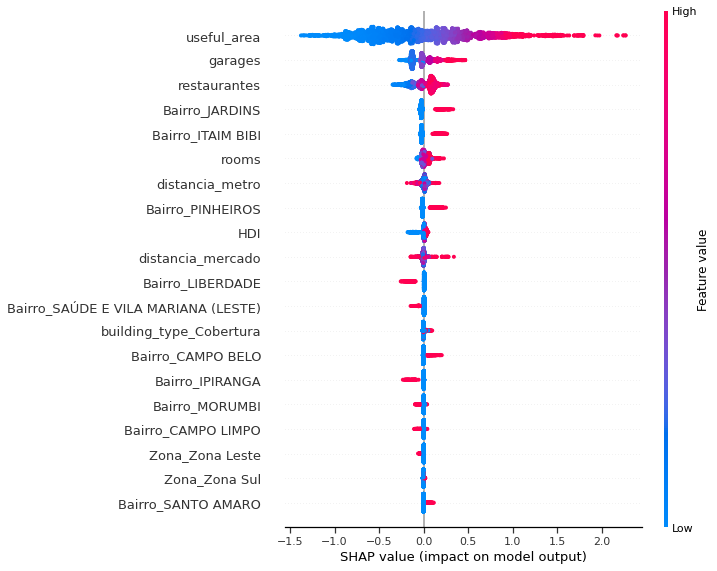

In [501]:
import shap
from shap import TreeExplainer
shap.initjs()
exp = TreeExplainer(xgb)

shap_vals = exp.shap_values(X_test)
shap_df = pd.DataFrame(shap_vals, columns=pd.Index(X_test.columns, name='features'))
shap.summary_plot(shap_vals, X_test)

In [502]:
X_tmp = X.reset_index()
X_tmp = X_tmp[X_tmp['index'].isin([7818,9315,18338])].set_index('index')
X_tmp

rooms  garages  useful_area  restaurantes  distancia_mercado  \
index                                                                 
7818     1.0        1           50       13480.0           0.498167   
9315     4.0        2          320       11806.0           0.157309   
18338    4.0        2          117        9432.0           0.945219   

       distancia_metro       HDI  Zona_Zona Leste  Zona_Zona Norte  \
index                                                                
7818          0.322821  0.797111                0                0   
9315          1.304322  0.797111                0                0   
18338         1.433641  0.797111                0                0   

       Zona_Zona Oeste  ...  Bairro_PINHEIROS  Bairro_SANTANA  \
index                   ...                                     
7818                 0  ...                 0               0   
9315                 0  ...                 0               0   
18338                0  ...                 0               0   

       Bairro_SANTO AMARO  Bairro_SAÚDE E VILA MARIANA (LESTE)  \
index                                                            
7818                    0                                    1   
9315                    0                                    0   
18338                   1                                    0   

       Bairro_SÃO LUCAS  Bairro_SÃO MATEUS  Bairro_TREMEMBÉ  \
index                                                         
7818                  0                  0                0   
9315                  0                  0                0   
18338                 0                  0                0   

       Bairro_VILA BUARQUE  Bairro_VILA MARIA  building_type_Cobertura  
index                                                                   
7818                     0                  0                        0  
9315                     0                  0                        1  
18338                    0                  0                        0  

[3 rows x 52 columns]

In [503]:
y_tmp = np.expm1(y[[7818,9315,18338]])

#### Apartamento 7818

In [507]:
shap_values = exp.shap_values(X_tmp.loc[[7818]])
shap.force_plot(exp.expected_value, shap_values[0,:], X_tmp.loc[[7818]])

#### Apartamento 9315

In [506]:
shap_values = exp.shap_values(X_tmp.loc[[9315]])
shap.force_plot(exp.expected_value, shap_values[0,:], X_tmp.loc[[9315]])

#### Apartamento 18338

In [508]:
shap_values = exp.shap_values(X_tmp.loc[[18338]])
shap.force_plot(exp.expected_value, shap_values[0,:], X_tmp.loc[[18338]])

In [522]:
precos_estimados = list(np.expm1(xgb.predict(X_tmp.copy())))

print(f'O dono do apartamento 7818 gostaria de vendê-lo por R$ 400000.\n O valor estimado é de R$ {round(precos_estimados[0])}\n')
print(f'O dono do apartamento 9315 gostaria de vendê-lo por R$ 3000000.\n O valor estimado é de R$ {round(precos_estimados[1])}\n')
print(f'O dono do apartamento 18338 gostaria de vendê-lo por R$ 2000000.\nO valor estimado é de R$ {round(precos_estimados[2])}\n')

O dono do apartamento 7818 gostaria de vendê-lo por R$ 400000.
 O valor estimado é de R$ 465028

O dono do apartamento 9315 gostaria de vendê-lo por R$ 3000000.
 O valor estimado é de R$ 3067953

O dono do apartamento 18338 gostaria de vendê-lo por R$ 2000000.
O valor estimado é de R$ 1198707

